# Notebook Data/Image Augmentation
## Proyecto X-Teeth
### Autor: José Miguel Ramírez Sanz 
### Modificado por: Ismael Franco Hernando
**Imports**

In [1]:
import cv2


import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
import IPython

import matplotlib.patches as ptc
from matplotlib import pyplot as plt
#from shapely.geometry.polygon import Polygon
#from descartes import PolygonPatch

%matplotlib inline

import os
import json
import numpy as np
np.set_printoptions(threshold=np.inf)
import pickle as pk

from tensorflow.keras import layers
import albumentations as A

## Obtener puntos e imágenes de JSONs
**Funciones**

In [2]:
"""
Función que dibuja un imagen con los puntos asocioados

:img: imagen que sobre la que se quiere imprimir los puntos
:puntos: lista de puntos [x,y] a imprimir
:imagen: booleano, True si queremos que salga la imagen original, False si no
:tamIm: tamaño de la imagen
:tamPunto: tamaño de los puntos
:color: color de los puntos
"""
def dibujarArea(img,puntos,imagen=False,tamPunto=5,color='r'):
    puntos=np.array(puntos)
    fig,ax=plt.subplots(1)
    tamIm=(img.shape[1]/72,img.shape[0]/72)
    fig.set_size_inches(tamIm[0],tamIm[1])
    plt.xlim([0, len(img[0])])
    plt.ylim([len(img),0])
    plt.plot(puntos[:,0],puntos[:,1])
    plt.fill(puntos[:,0],puntos[:,1],color="skyblue")
    plt.axis('off')
    if imagen:
        ax.imshow(img)
    plt.show() 
    return fig

In [3]:
"""
Función que almacena los puntos de un fichero en una carpeta

:fichero: fichero JSON del que se quieren obtener los puntos
:carpeta: carpeta de salida donde se almacena la lista en un pickle
"""
def guardarPuntos(fichero, carpeta):
    with open(fichero) as file:
        data = json.load(file)
    fichero=fichero.split("/")[-1]
    f=fichero.split("_")[0]
    
    #Si es el caso especial del primer dato (tiene estructura especial)
    if(f=="Datos1"):
        data=data['_via_img_metadata']
    
    #En los primeros es el 0, pero ahora es el 2 porque lo han hecho mal
    #print(list(data.keys())[2])
    data=data[list(data.keys())[0]]

    dataX=data['regions'][0]['shape_attributes']['all_points_x']
    dataY=data['regions'][0]['shape_attributes']['all_points_y']
    
    puntos=[]
    for i in range(len(dataX)):
        puntos.append([dataX[i],dataY[i]])
    #print(puntos)
    
    existeDir(carpeta+"/Puntos")
    
    with open(carpeta+"/Puntos/"+fichero.split(".")[0]+".pk", 'wb') as f:
        pk.dump(puntos, f)

In [4]:
"""
Función que obtiene los puntos de todos los archivos de una carpeta

:dirEnt: directorio de entrada, donde están los JSONs
:dirSal: directorio donde se almacenan los pickles
:imp: booleano, True si se imprime el nombre del fichero procesado

Devuelve el path a los puntos
"""
def obtenerPuntos(dirEnt, dirSal, imp=False):
    existeDir(dirSal)
    for i in os.listdir(dirEnt):
        if i != ".ipynb_checkpoints" and i != "Puntos":
            if imp:
                print(i)
            guardarPuntos(dirEnt+"/"+i,dirSal)
    return dirSal+"/Puntos"

In [5]:
"""
Función que comprueba si existe un directorio y sino lo crea

:path: ruta directorio a comprobar/crear
"""
def existeDir(path):
    if not os.path.isdir(path):
        os.makedirs(path,exist_ok=True)

In [6]:
"""
Función que obtiene las máscaras de los puntos con o sin imagen

:dirEnt: directorio donde se encuentran las imágenes
:dirPun: directorio donde se encuentran los puntos
:dirSal: directorio donde se almacenarán las imágenes
:imangen: booleano, True si queremos que se vea la imagen original de fondo
:imp: boolano, True si se imprime el nombre del fichero procesado
"""
def obtenerImagenes(dirEnt, dirPun, dirSal, imagen = False,imp = False):
    existeDir(dirSal)
    for i in os.listdir(dirEnt):
        if i != ".ipynb_checkpoints":
            if imp:
                print(i)
            img = cv2.imread(dirEnt+"/"+i)
            nom = i.split(".")[0]
            puntos_1 = pk.load(open(dirPun+"/"+nom+"_1.pk","rb"))
            puntos_2= pk.load(open(dirPun+"/"+nom+"_2.pk","rb"))
            aux_1=dibujarArea(img,puntos_1,imagen=imagen)
            aux_1.savefig(dirSal+"/"+nom+"_1.png",bbox_inches='tight',pad_inches = 0)
            img1=cv2.imread(dirSal+"/"+nom+"_1.png")            
            img1=cv2.resize(img1,(img.shape[1],img.shape[0]))
            cv2.imwrite(dirSal+"/"+nom+"_1.png",img1)
            
            aux_2=dibujarArea(img,puntos_2,imagen=imagen)
            aux_2.savefig(dirSal+"/"+nom+"_2.png",bbox_inches='tight',pad_inches = 0)
            img2=cv2.imread(dirSal+"/"+nom+"_2.png")            
            img2=cv2.resize(img2,(img.shape[1],img.shape[0]))
            cv2.imwrite(dirSal+"/"+nom+"_2.png",img2)

**Ejecución**

In [7]:
p=obtenerPuntos("Datos/Segmentacion/","Datos/Pruebas")

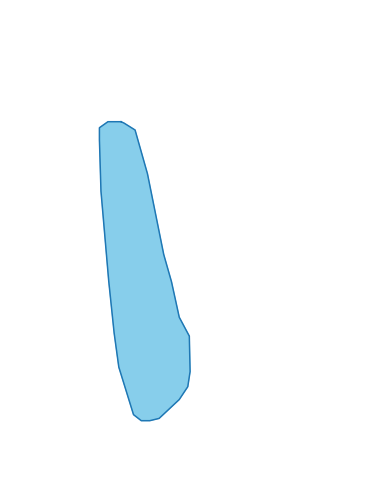

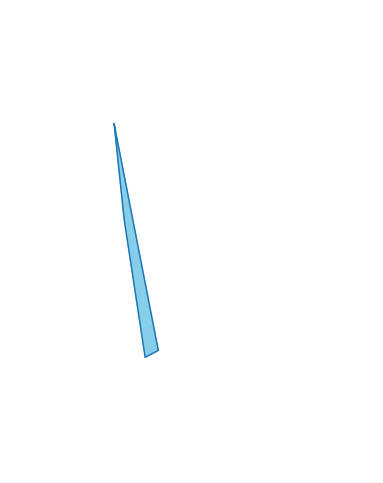

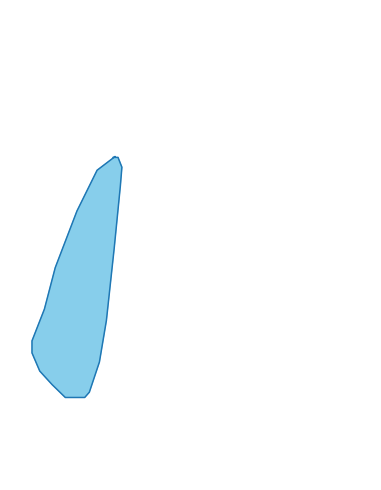

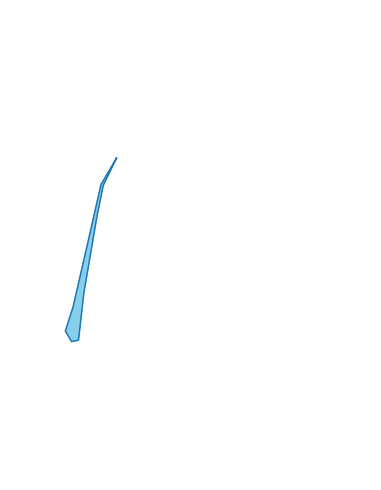

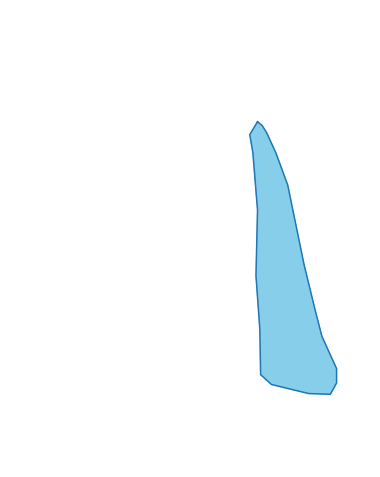

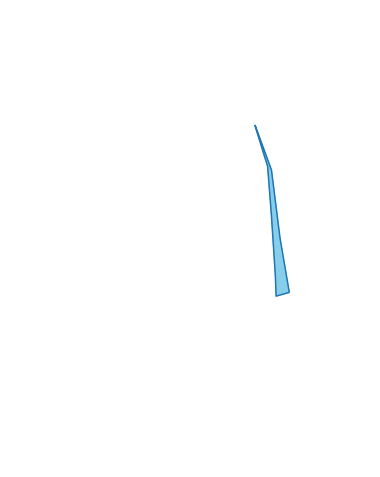

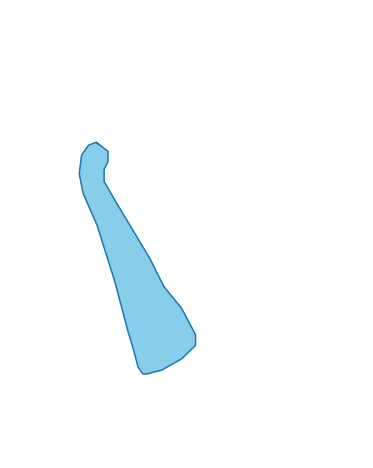

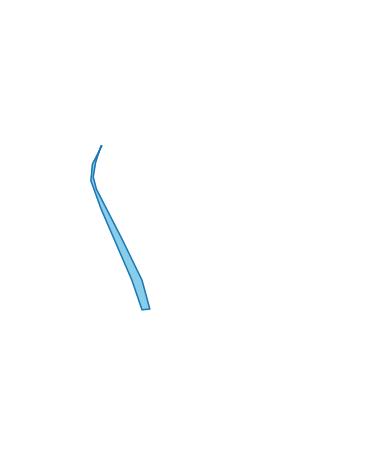

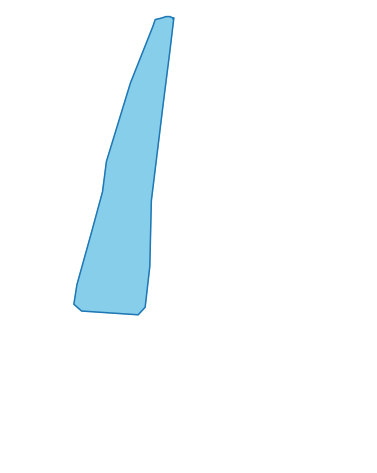

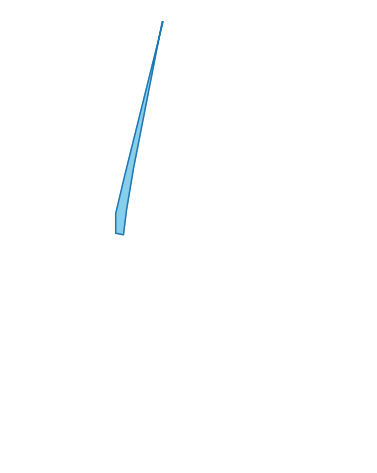

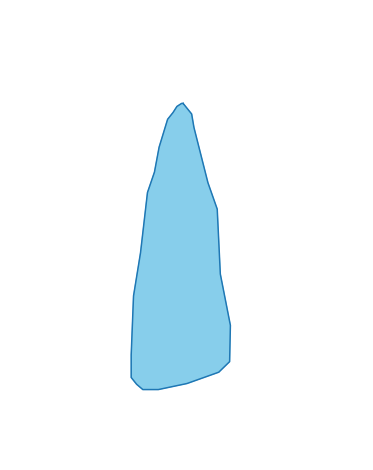

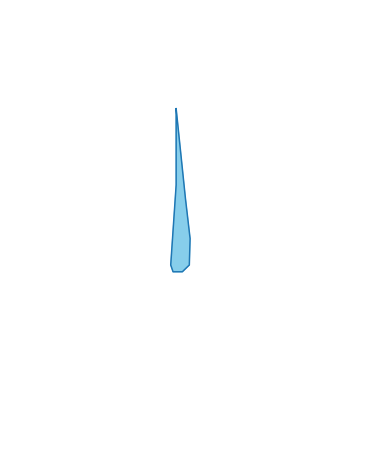

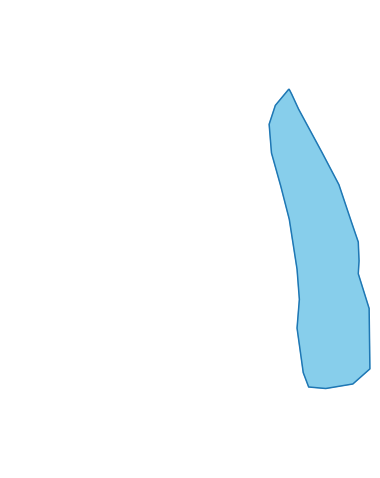

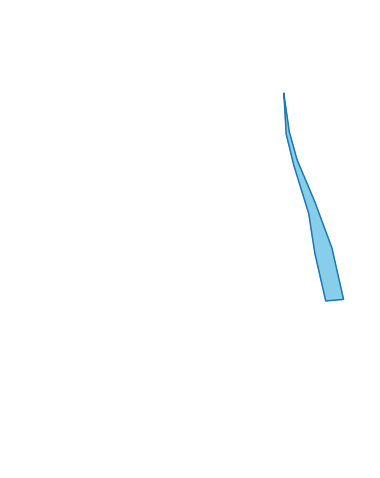

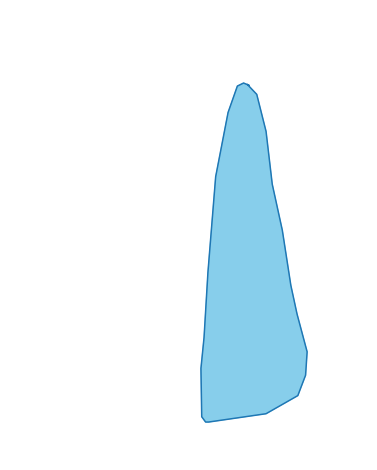

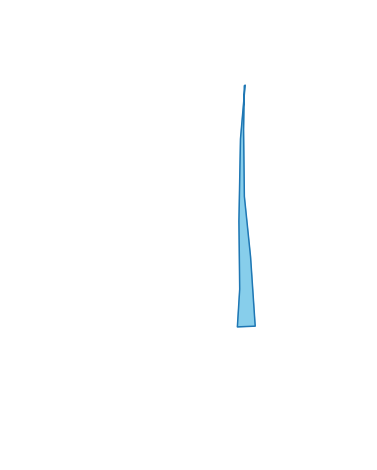

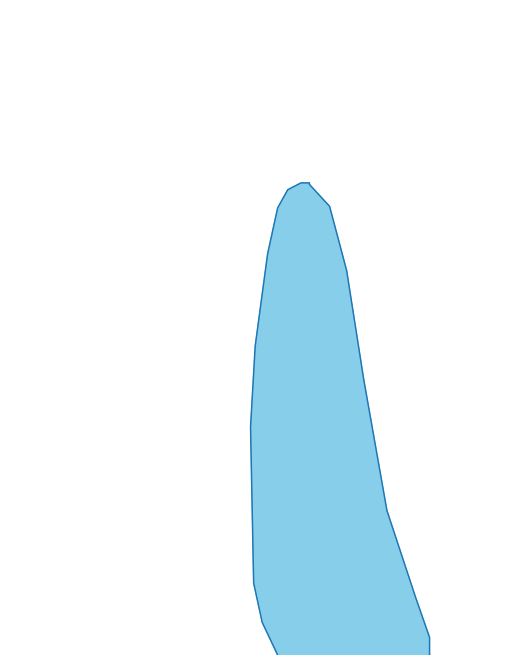

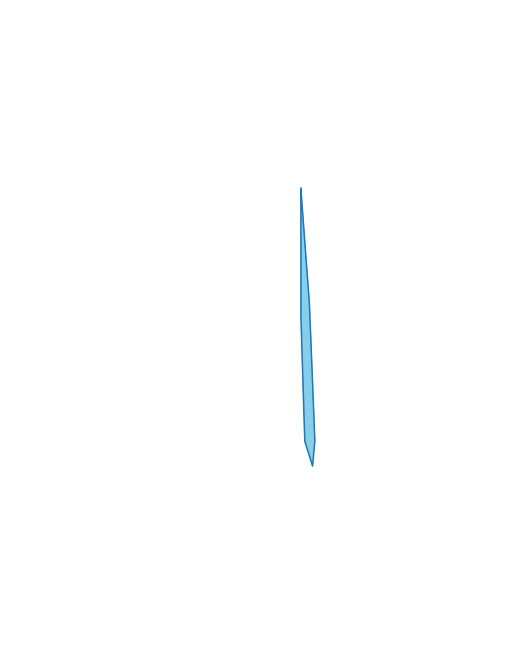

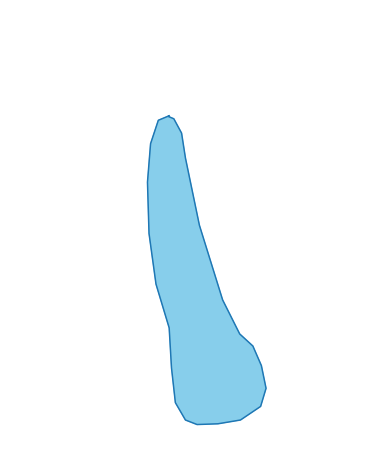

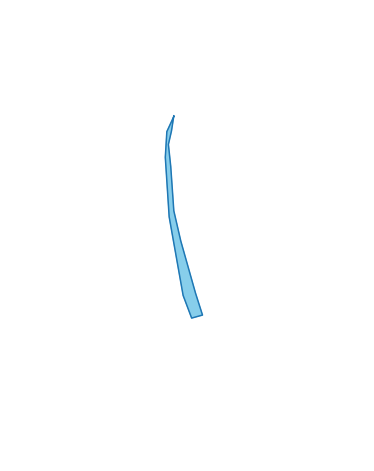

In [8]:
obtenerImagenes("Datos/Reales",p,"Datos/Pruebas/Mascara/SinImagen")

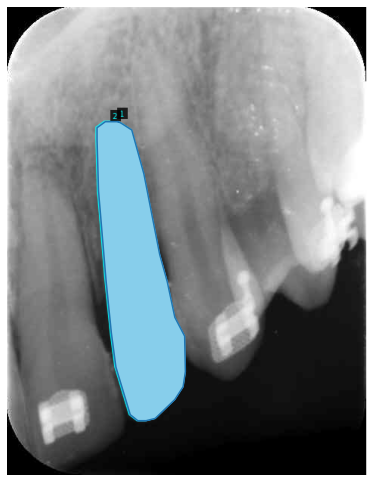

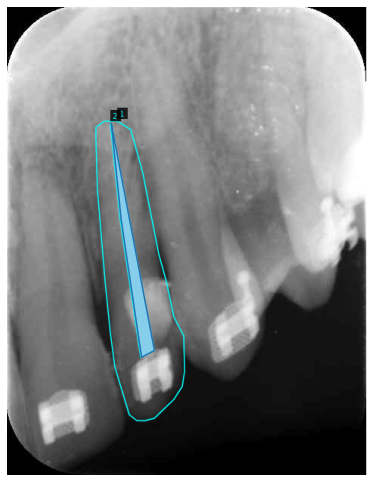

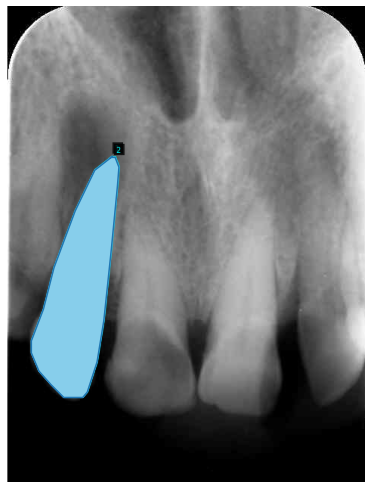

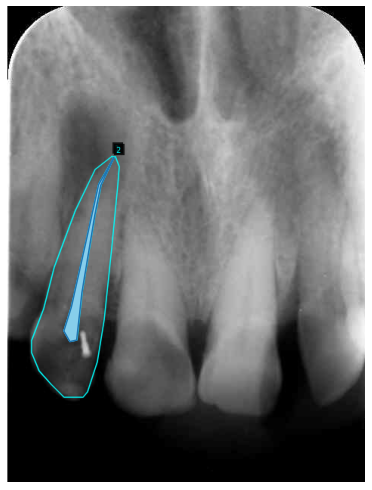

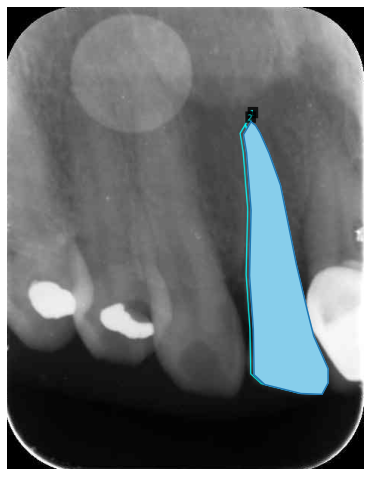

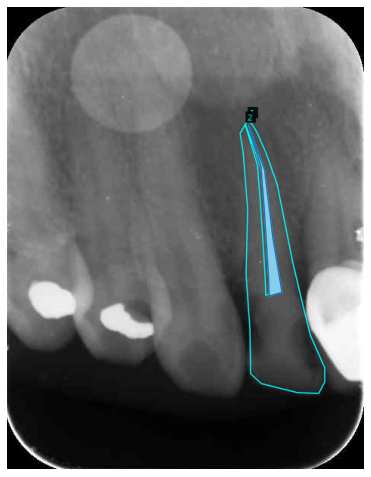

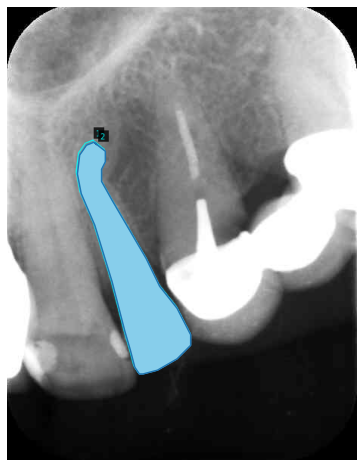

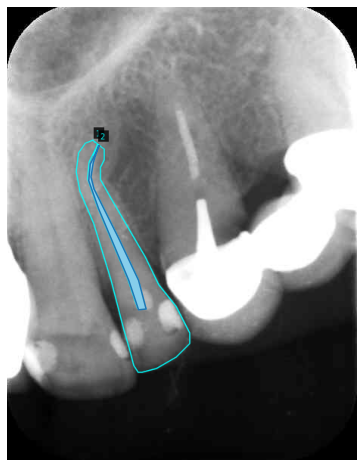

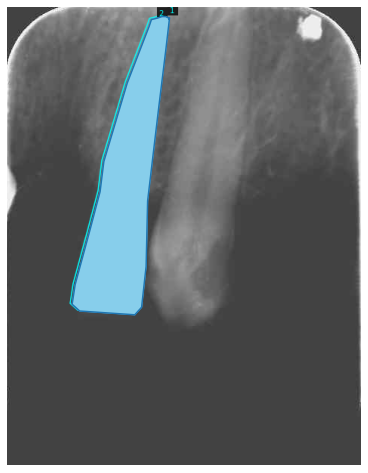

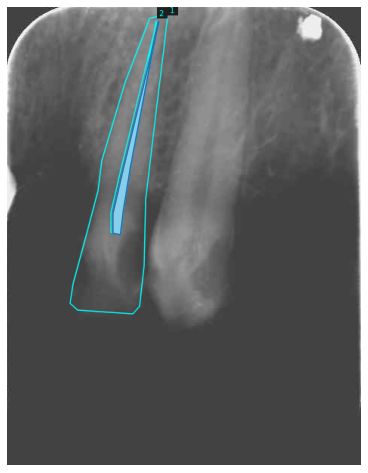

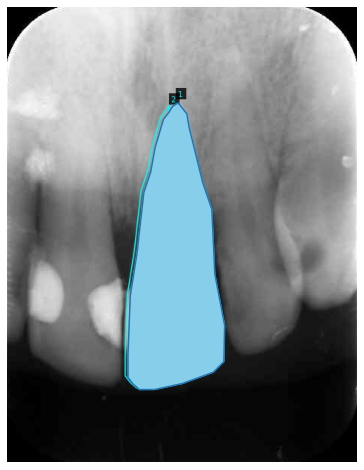

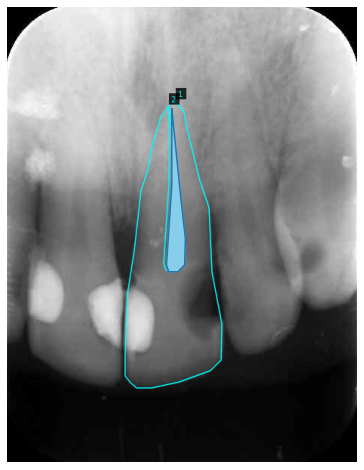

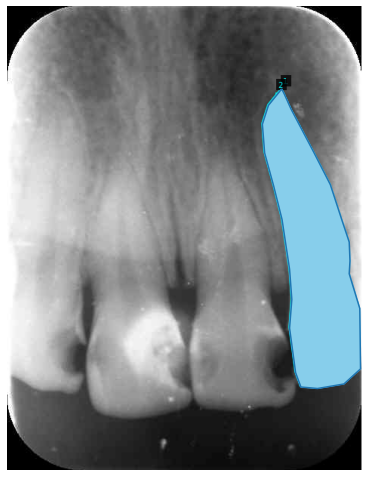

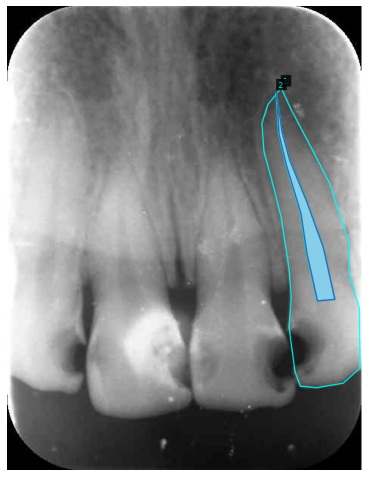

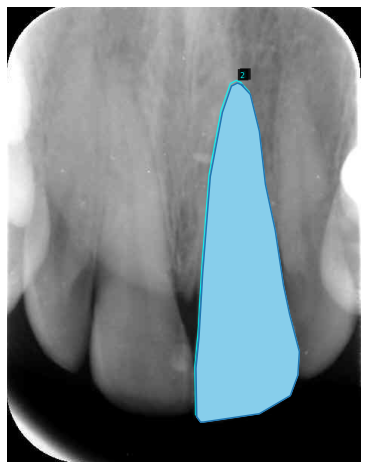

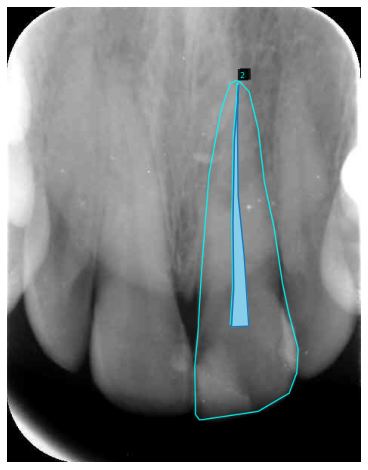

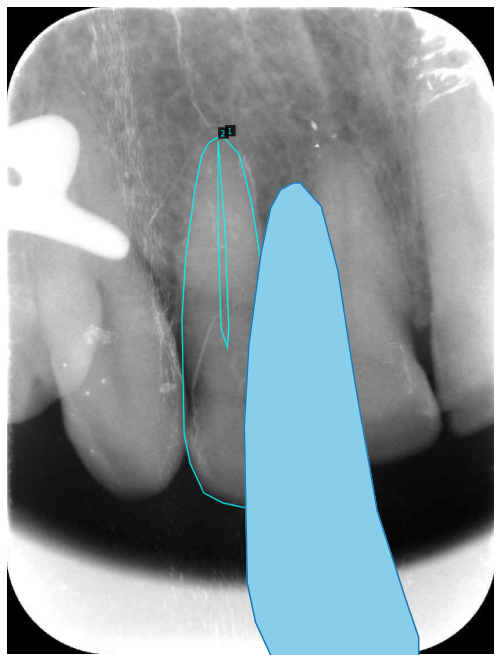

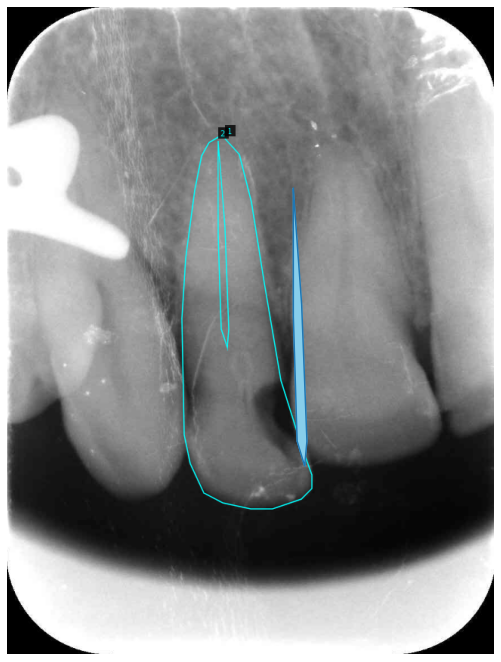

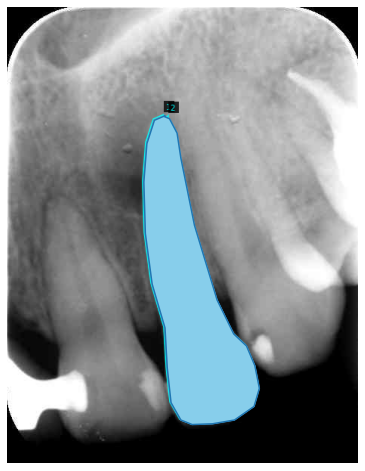

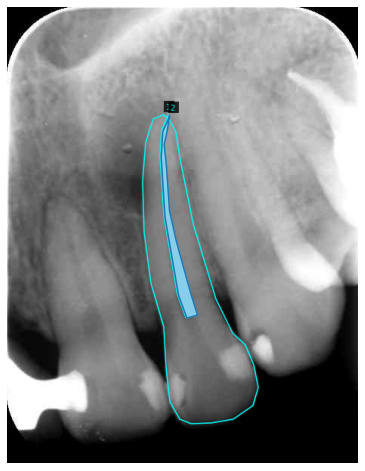

In [9]:
obtenerImagenes("Datos/Reales",p,"Datos/Pruebas/Mascara/ConImagen",imagen=True)

## Data Augmentation
**Transformación a aplicar**

In [10]:
"""
Función que realiza el aumento de los datos a partir de imágenes, máscaras y una función de transformación

:dirEnt: directorio en donde se encuentran las imágenes originales
:dirMas: directorio en donde se encuentran las imágenes de las máscaras sin la imagen original
:transform: función de transformación de albumentations
"""
def dataAugmentation(dirEnt, dirMas, dirSal,transform):
    img={}
    for i in os.listdir(dirEnt):
        if i != ".ipynb_checkpoints":
            img[i]=cv2.imread(dirEnt+"/"+i)
    imgMas={}
    for i in os.listdir(dirEnt):
        if i != ".ipynb_checkpoints":
            iaux=i.split(".")[0]
            imgMas[i]=[cv2.imread(dirMas+"/"+iaux+"_1.png"),cv2.imread(dirMas+"/"+iaux+"_2.png")]
    
    #Imágenes sin máscara en Imagen
    existeDir(dirSal+"/Imagen")
    #Un tipo de máscaras en 1
    existeDir(dirSal+"/1")
    #El otro tipo en 2
    existeDir(dirSal+"/2")
    for i in img:
        cv2.imwrite(dirSal+"/Imagen/"+str(i).split(".")[0]+"_Real.png",np.array(img[i]))
        cv2.imwrite(dirSal+"/1/"+str(i).split(".")[0]+"_Real.png",np.array(imgMas[i][0]))
        cv2.imwrite(dirSal+"/2/"+str(i).split(".")[0]+"_Real.png",np.array(imgMas[i][1]))
        for j in range(10): 
            transformed = transform(image=img[i], masks=imgMas[i])
            image = transformed['image']
            mask = transformed['masks']
            
            for z in range(len(mask)):                
                for fila in range(mask[z].shape[0]):
                    for columna in range(mask[z].shape[1]):
                        b,g,r = mask[z][fila,columna]
                        if b==0 and g==0 and r==0:
                            mask[z][fila,columna]=[255,255,255]

            cv2.imwrite(dirSal+"/Imagen/"+str(i).split(".")[0]+"_"+str(j)+".png",image)
            cv2.imwrite(dirSal+"/1/"+str(i).split(".")[0]+"_"+str(j)+".png",mask[0])
            cv2.imwrite(dirSal+"/2/"+str(i).split(".")[0]+"_"+str(j)+".png",mask[1])            

**Prueba con una transformación**

In [13]:
transform = A.Compose([
    A.GaussNoise(always_apply=False, p=1.0, var_limit=(10.0, 50.0)),
    A.Rotate(always_apply=False, p=0.5, limit=(-45, 45), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
    #A.GridDistortion(always_apply=False, p=0.5, num_steps=5, distort_limit=(-0.3, 0.3), interpolation=0, border_mode=0, value=(0, 0, 0), mask_value=None),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    #A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    #A.RandomBrightnessContrast(p=0.2),
])

In [14]:
dataAugmentation("Datos/Reales","Datos/Pruebas/Mascara/SinImagen","Datos/Pruebas/Aumentos",transform)